# Pneumonia X-ray case, image recognition using CNN.

# Overview
With the increasing number of pneumonia cases during COVID hospitals are overwhelmed with additional work. Some of the methods that are used to diagnosed COVID is by making X rays of chrest. I was hired by a local hospital to create a model that can automatically classify person on having or not pneumonia based on X-ray. This system should have high accuracy and high recall.

To acheive this goal, We used image recognition with DeepLearning techniques including CNN and pretrained CNN. 


# Business Understanding
Our stakeholder wants to have model that can be reliable in predicting when person have pneumonia.

# Data

1) Chest X-Ray Images. Year: 2018 
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3

https://data.mendeley.com/datasets/rscbjbr9sj/3


# Metrics
#### Our project will answer following question:
Can we predict people with pneumonia based on their chrest X-ray?

#### Hypothesis:
H0 - Person has pneumonia

HA - There is statisticaly significant proof that the preson doesnt' have pneumonia

#### TP, TN, FP, FN definition
TP - we predicted pneumonia and it actually exist.

TN - we predicted that person didn't have pneumonia and the person actually didn't have it.

FP - We predicted pneumonia but there was no pneumonia in real life.

FN - We predicted that there is no pneumonia but it actually existed.


#### Metrics used  
To compare models we will focus on 2 major metrics:

Recall - Health of people is our priority, we will be focused to minimize FN.
##### Business requirement: our system should have at least 95% recall. 

Accuracy - how good we can predict TP and TN. General metrics that will show model performance.




# Data Understanding
#### Sources of data:
1) Chest X-Ray Images. Year: 2018 
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3

https://data.mendeley.com/datasets/rscbjbr9sj/3

#### Main dataset contains the following images:
Train set:

There are 1349 normal images, image name example, NORMAL-2552119-0002.jpeg

There are 4489 pneumonia images, image name example, BACTERIA-4038442-0001.jpeg

Test set:

There are 234 normal images, image name example, NORMAL-8698006-0001.jpeg

There are 390 pneumonia images, image name example, VIRUS-2040583-0001.jpeg


# Data Cleaning
### Importing required modules

In [1]:
# Work with data
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve, plot_roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop


#Other
import pickle
import time
import os, shutil 
import scipy
from PIL import Image
from scipy import ndimage
import itertools

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
simplefilter(action='ignore', category= FutureWarning)
simplefilter(action='ignore', category= ConvergenceWarning)
simplefilter(action='ignore', category= FitFailedWarning)
simplefilter(action='ignore', category= UserWarning)

### Data preparation

Below we create three objects representing the existing directories: `data/normal/` as `data_normal_dir` and `data/pneumonia/` as `data_pneumonia_dir`, `data/test/normal/` as `test/normal` and `data/test/pneumonia/` as `test/pneumonia`. We will create a new directory `split/` as `new_dir`, where we will split the dataset in three groups (or three subdirectories): `train`, `test`, and `validation`, each containing `normal` and `pneumonia` subfolders. The final desired structure is represented below: 

![title](images/folder_structure.png)

In [2]:
data_normal_dir = 'data/normal/'
data_pneumonia_dir = 'data/pneumonia/'
new_dir = 'data/split/'
data_test_normal_dir = 'data/test/normal/'
data_test_pneumonia_dir = 'data/test/pneumonia/'

In [3]:
# Train set
imgs_normal = [file for file in os.listdir(data_normal_dir) if file.endswith('.jpeg')]
imgs_pneumonia = [file for file in os.listdir(data_pneumonia_dir) if file.endswith('.jpeg')]
# Test set
imgs_normal_test = [file for file in os.listdir(data_test_normal_dir) if file.endswith('.jpeg')]
imgs_pneumonia_test = [file for file in os.listdir(data_test_pneumonia_dir) if file.endswith('.jpeg')]

In [4]:
os.listdir(data_normal_dir)[0]

'NORMAL-2552119-0002.jpeg'

In [5]:
print("Train set:")
print('There are', len(imgs_normal), 'normal images, image name example,',os.listdir(data_normal_dir)[0])
print('There are', len(imgs_pneumonia), 'pneumonia images, image name example,',os.listdir(data_pneumonia_dir)[0])
print("Test set:")
print('There are', len(imgs_normal_test), 'normal images, image name example,',os.listdir(data_test_normal_dir)[0])
print('There are', len(imgs_pneumonia_test), 'pneumonia images, image name example,',os.listdir(data_test_pneumonia_dir)[0])


Train set:
There are 1349 normal images, image name example, NORMAL-2552119-0002.jpeg
There are 4489 pneumonia images, image name example, BACTERIA-4038442-0001.jpeg
Test set:
There are 234 normal images, image name example, NORMAL-8698006-0001.jpeg
There are 390 pneumonia images, image name example, VIRUS-2040583-0001.jpeg


Make new split directory

In [6]:
os.mkdir(new_dir)

Create new directories

In [7]:
# Define path
train_folder = os.path.join(new_dir, 'train')
train_normal = os.path.join(train_folder, 'normal')
train_pneumonia = os.path.join(train_folder, 'pneumonia')

test_folder = os.path.join(new_dir, 'test')
test_normal = os.path.join(test_folder, 'normal')
test_pneumonia = os.path.join(test_folder, 'pneumonia')

val_folder = os.path.join(new_dir, 'validation')
val_normal = os.path.join(val_folder, 'normal')
val_pneumonia = os.path.join(val_folder, 'pneumonia')

In [8]:
# Check that path is ok
train_pneumonia

'data/split/train/pneumonia'

In [9]:
# Create directories
os.mkdir(test_folder)
os.mkdir(test_normal)
os.mkdir(test_pneumonia)

os.mkdir(train_folder)
os.mkdir(train_normal)
os.mkdir(train_pneumonia)

os.mkdir(val_folder)
os.mkdir(val_normal)
os.mkdir(val_pneumonia)

Copy images

In [10]:
# Define validation set.
validation_ratio = 0.15

In [11]:
# Setting size of validation set
val_set_norm = int(len(os.listdir(data_normal_dir))*validation_ratio)
val_set_pneumo = int(len(os.listdir(data_pneumonia_dir))*validation_ratio)

In [12]:
val_set_pneumo

673

In [13]:
# train normal
imgs_train_norm = imgs_normal[:len(os.listdir(data_normal_dir))-val_set_norm]
for img in imgs_train_norm:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(train_normal, img)
    shutil.copyfile(origin, destination)
# train pneumonia
imgs_train_pneumonia = imgs_pneumonia[:len(os.listdir(data_pneumonia_dir))-val_set_pneumo]
for img in imgs_train_pneumonia:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(train_pneumonia, img)
    shutil.copyfile(origin, destination)


In [14]:
len(imgs_pneumonia[len(os.listdir(data_pneumonia_dir))-val_set_pneumo:])

673

In [15]:
len(imgs_train_pneumonia)

3816

In [16]:
# validation set
imgs = imgs_normal[len(os.listdir(data_normal_dir))-val_set_norm:]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(val_normal, img)
    shutil.copyfile(origin, destination)

imgs = imgs_pneumonia[len(os.listdir(data_pneumonia_dir))-val_set_pneumo:]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(val_pneumonia, img)
    shutil.copyfile(origin, destination)

In [17]:
# test normal
imgs = imgs_normal_test
for img in imgs:
    origin = os.path.join(data_test_normal_dir, img)
    destination = os.path.join(test_normal, img)
    shutil.copyfile(origin, destination)
# test pneumonia
imgs = imgs_pneumonia_test
for img in imgs:
    origin = os.path.join(data_test_pneumonia_dir, img)
    destination = os.path.join(test_pneumonia, img)
    shutil.copyfile(origin, destination)   


Check the folders:

In [18]:
# Train images
train_img_number = len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia))
# Validation images
val_img_number = len(os.listdir(val_normal)) + len(os.listdir(val_pneumonia))
# Test images
test_img_number = len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia))


In [19]:
print('Training set:',train_img_number, "images" )
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print('Validation set:', val_img_number, "images" )
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')
print('Test set:', test_img_number, 'images')
print('There are', len(os.listdir(test_normal)), 'normal images in the test set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the test set')


Training set: 4963 images
There are 1147 normal images in the training set
There are 3816 pneumonia images in the training set
Validation set: 875 images
There are 202 normal images in the validation set
There are 673 pneumonia images in the validation set
Test set: 624 images
There are 234 normal images in the test set
There are 390 pneumonia images in the test set


### Setting up help functions:

##### Results visualization:

In [20]:
# Plots of losses.
def visualize_training_results(results):
    # Create figures
    fig, (left, right) = plt.subplots(1,2, figsize = (16,6))
    history = results.history
    # Loss functions plot
    left.plot(history['val_loss'], label = "val loss")
    left.plot(history['loss'], label = "loss")
    left.set_title('Loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Loss')
    left.legend()
    # Accuracy plot
    right.plot(history['val_accuracy'], label = "val accuracy")
    right.plot(history['accuracy'], label = "accuracy")
    right.set_title('Accuracy')
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    right.legend()
    path = "./img/Loss_"+model_name+".png"
    plt.savefig(path)
    plt.show()
    
    

In [21]:
# Create data with aug
def process_data_aug(img_size, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range=20,   
                                       zoom_range=0.2,
                                       width_shift_range=0.2, 
                                       height_shift_range=0.2,
                                       vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_generator = train_datagen.flow_from_directory(
      directory=train_folder, 
      target_size=img_size, 
      batch_size=92, 
      class_mode='binary',
      shuffle = True)

    val_generator = test_val_datagen.flow_from_directory(
      directory=val_folder, 
      target_size=img_size, 
      batch_size=32, 
      class_mode='binary',
      shuffle = True)
    
    test_generator = test_val_datagen.flow_from_directory(
        test_folder, 
        target_size=img_size, 
        batch_size = test_img_number)  
    
    
    return train_generator, val_generator, test_generator



In [22]:
# Create data without aug
def process_data_no_aug(img_size):
    # Data generation objects
    # get all the data in the directory split/train, and reshape them
    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=img_size, batch_size= train_img_number)

    # get all the data in the directory split/validation, and reshape them
    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=img_size, batch_size = val_img_number)

    # get all the data in the directory split/test, and reshape them
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=img_size, batch_size = test_img_number) 

    
    
    return train_generator, val_generator, test_generator



In [23]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    path = "./img/CM_"+model_name+".png"
    plt.savefig(path)
    plt.show()

In [24]:
# Plot results:
# - Loss, accuracy for val and train sets during training. 
# - Confusion matrix for test results. 

def plot_results(results, model, test_images,  test_y =None, threshold = 0.5,):
    visualize_training_results(results)
    predictions = model.predict(test_images)
    predictions = [1 if x > threshold else 0 for x in predictions]
    accuracy = accuracy_score(test_y, predictions)
    recall = recall_score(test_y, predictions)
    print('Test Accuracy = %.2f' % accuracy)# Combined plotting. 

    print('Recall = %.2f' % recall)
    confusion_mtx = confusion_matrix(test_y, predictions)
    cm = plot_confusion_matrix(confusion_mtx, classes = ["normal", "pneumonia"], normalize=False)

In [25]:
# Create dataframe with finall results.
result_columns = ["Model name","Image size","Parameters","Train time","Train accuracy", "Validation accuracy", "Test accuracy", "Test Recall"]
results_df = pd.DataFrame(columns = result_columns)

                  
# Results:
def make_results(model_selection, image_size, train_time,model_name, results, model, test_images, test_y, threshold = 0.5):
    predictions = model.predict(test_images)
    predictions = [1 if x > threshold else 0 for x in predictions]
    test_accuracy = round(accuracy_score(test_y, predictions),4)
    test_recall = round(recall_score(test_y, predictions),4)
    train_accuracy = round(results.history["accuracy"][-1],4)
    val_accuracy = round(results.history["val_accuracy"][-1],4)
    train_epoch = len(results.epoch)
    N_of_params = int(np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables]) + np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_variables]))
    line = pd.DataFrame(np.array([[model_name, image_size, N_of_params,
                               train_time, train_accuracy, val_accuracy,
                               test_accuracy, test_recall]]), columns = result_columns)
    model_selection = pd.concat([model_selection,line], axis = 0)
    return model_selection

### Use a densely connected network as a baseline

##### Prepare images

##### 64x64 images without data augmentation

In [26]:
image_size = (64,64)
train_generator, val_generator, test_generator = process_data_no_aug(image_size)

Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
# Prepare images and lables.
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [28]:
# Explore dataset
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4963
Number of testing samples: 624
Number of validation samples: 875
train_images shape: (4963, 64, 64, 3)
train_labels shape: (4963, 2)
test_images shape: (624, 64, 64, 3)
test_labels shape: (624, 2)
val_images shape: (875, 64, 64, 3)
val_labels shape: (875, 2)


##### Visualize data

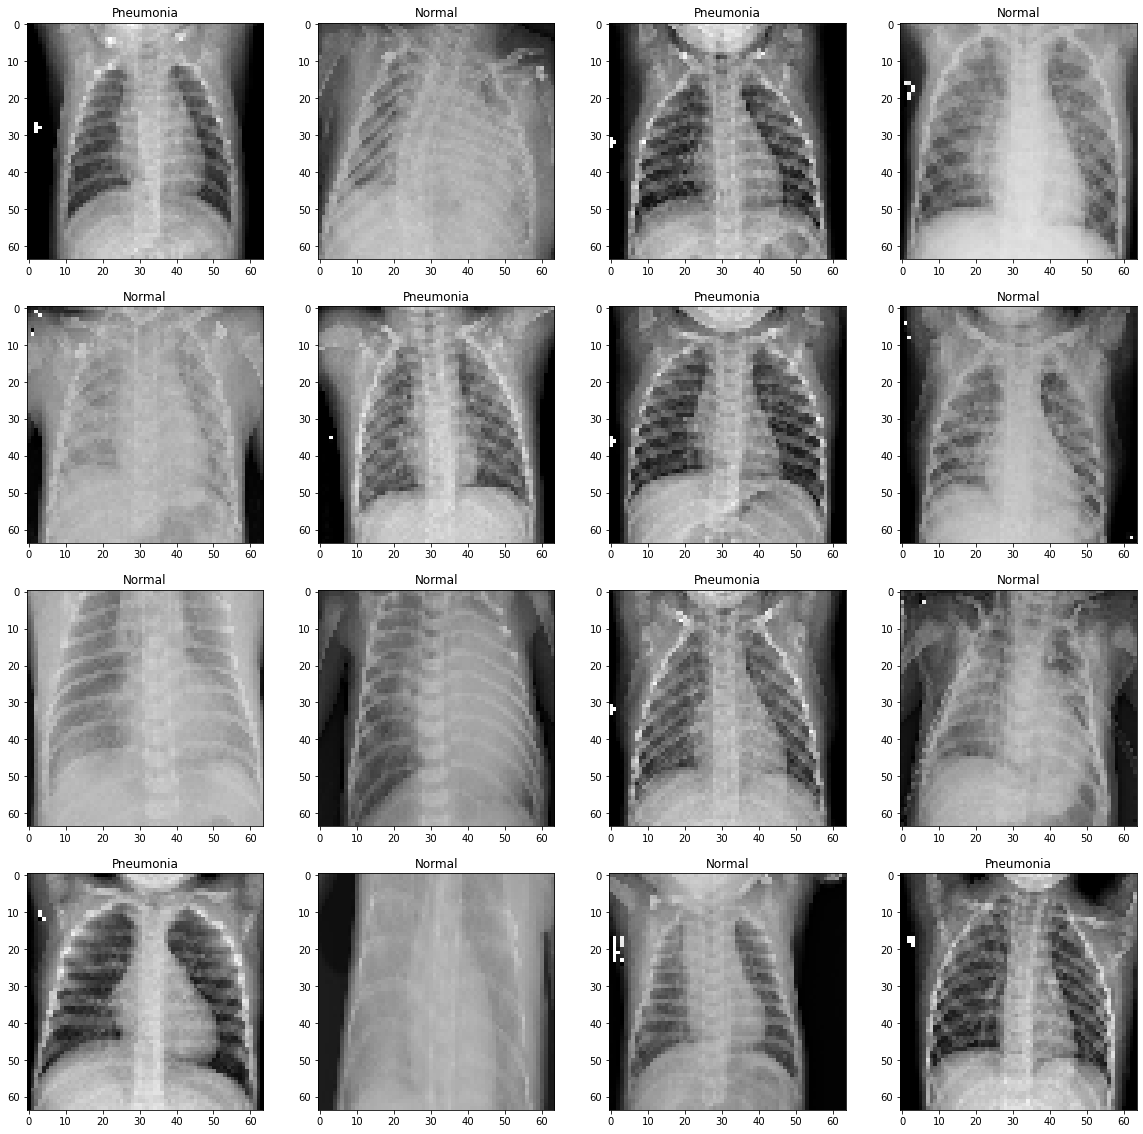

In [29]:
# plot 16 random photos of normal and pneumonia X-ray
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))

for x in range(0,4):
    for y in range(0, 4):
        i = np.random.randint(0,len(train_images))
        axes[x][y].imshow(train_images[i])
        
        if train_labels[i][0] == 0:
            axes[x][y].set_title('Normal')
        else:
            axes[x][y].set_title('Pneumonia')

In [30]:
# Finall features set:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4963, 12288)
(624, 12288)
(875, 12288)


In [31]:
# Labels. 
train_y = np.reshape(train_labels[:,0], (train_img_number,1))
test_y = np.reshape(test_labels[:,0], (test_img_number,1))
val_y = np.reshape(val_labels[:,0], (val_img_number,1))

##### 1) Prepare 1st Baseline mode.

In [32]:
# Initialize 1st mode.

np.random.seed(123)
model_name = "Baseline_model"
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],))) # 2 hidden layers
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2022-02-17 16:31:14.394427: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
# Train model
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

start = time.time()
history_base = model.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model.save(savepath)

Epoch 1/20
156/156 [==============================] - 1s 5ms/step - loss: 0.4490 - accuracy: 0.7925 - val_loss: 0.6565 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 1s 4ms/step - loss: 0.3278 - accuracy: 0.8672 - val_loss: 0.3731 - val_accuracy: 0.8331
Epoch 3/20
156/156 [==============================] - 1s 4ms/step - loss: 0.2489 - accuracy: 0.8993 - val_loss: 0.2532 - val_accuracy: 0.8891
Epoch 4/20
156/156 [==============================] - 1s 3ms/step - loss: 0.2073 - accuracy: 0.9176 - val_loss: 0.1726 - val_accuracy: 0.9303
Epoch 5/20
156/156 [==============================] - 1s 3ms/step - loss: 0.1718 - accuracy: 0.9333 - val_loss: 0.2375 - val_accuracy: 0.9017
Epoch 6/20
156/156 [==============================] - 1s 4ms/step - loss: 0.1772 - accuracy: 0.9315 - val_loss: 0.2411 - val_accuracy: 0.9063
Epoch 7/20
156/156 [==============================] - 1s 3ms/step - loss: 0.1731 - accuracy: 0.9331 - val_loss: 2.3864 - val_accuracy: 0.2571
Epoch 

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915


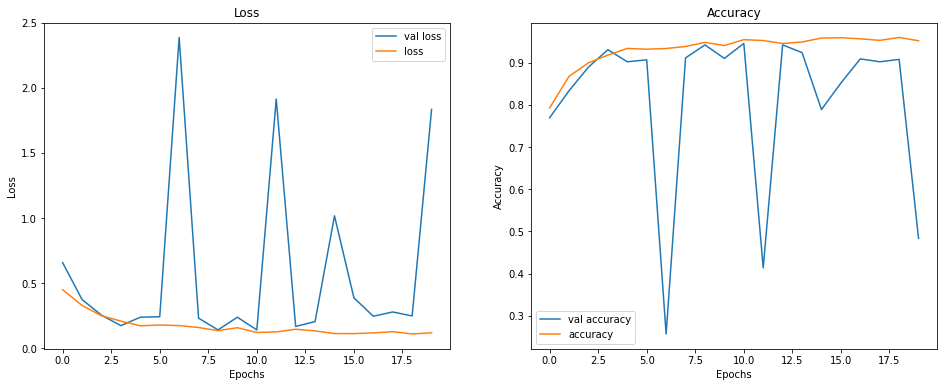

Test Accuracy = 0.63
Recall = 0.99


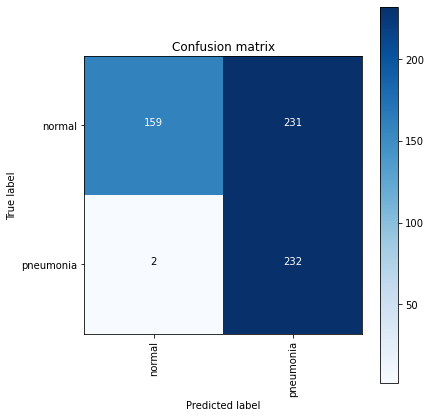

In [34]:
# process results

results_df = make_results(results_df,image_size,train_time,model_name,history_base, model, test_img, test_y)
display(results_df)
plot_results(history_base, model, test_img,  test_y,)

##### 2) Baseline model with regulization

We will use L2 regulization in each layer, to reduce overfitting.
Will try different L2 coefficients to determine the best one

In [36]:
# Lets find the best L2 value.

In [37]:
L2_list = [0.001, 0.01, 0.1, 1]

In [38]:
L2_fin = []
for L2 in L2_list:
    model2 = models.Sequential()
    model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2))) 
    model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2)))
    model2.add(layers.Dense(1, activation='sigmoid'))
    model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 0)
    results_test = model2.evaluate(test_img, test_y)
    L2_fin.append((L2, results_test[1]))
        


20/20 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.6250


In [39]:
L2_best = sorted(L2_fin, key = lambda x: x[1], reverse = True)[0][0]
print("Best L2 regulization parameter:", L2_best)

Best L2 regulization parameter: 0.1


In [40]:
# Model with regulization

In [41]:
model_name = "Baseline with reg"
model2 = models.Sequential()
model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

start = time.time()
history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 1)
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model2.save(savepath)



Epoch 1/20
156/156 [==============================] - 2s 10ms/step - loss: 11.4592 - accuracy: 0.7844 - val_loss: 8.3783 - val_accuracy: 0.8583
Epoch 2/20
156/156 [==============================] - 1s 9ms/step - loss: 6.2976 - accuracy: 0.8598 - val_loss: 5.6212 - val_accuracy: 0.2331
Epoch 3/20
156/156 [==============================] - 1s 10ms/step - loss: 3.5703 - accuracy: 0.8829 - val_loss: 2.9642 - val_accuracy: 0.7166
Epoch 4/20
156/156 [==============================] - 2s 10ms/step - loss: 2.1085 - accuracy: 0.8918 - val_loss: 1.6550 - val_accuracy: 0.8640
Epoch 5/20
156/156 [==============================] - 1s 9ms/step - loss: 1.3245 - accuracy: 0.9019 - val_loss: 1.0763 - val_accuracy: 0.8869
Epoch 6/20
156/156 [==============================] - 1s 9ms/step - loss: 0.9149 - accuracy: 0.9011 - val_loss: 1.8619 - val_accuracy: 0.2320
Epoch 7/20
156/156 [==============================] - 1s 9ms/step - loss: 0.6948 - accuracy: 0.8966 - val_loss: 1.2602 - val_accuracy: 0.4400
Ep

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0


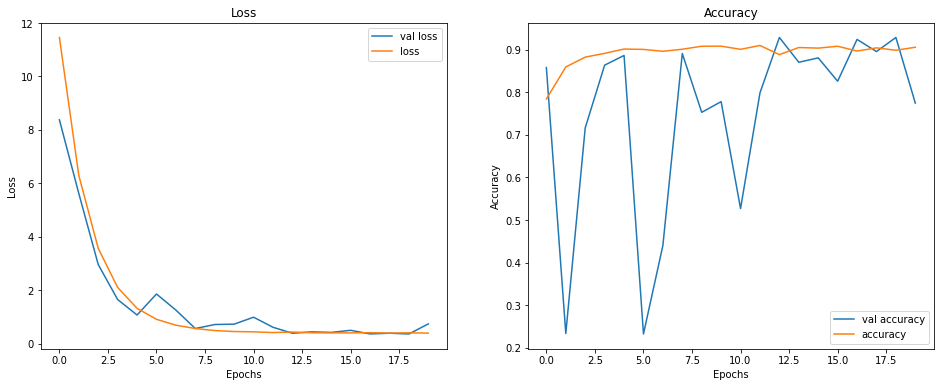

Test Accuracy = 0.62
Recall = 0.00


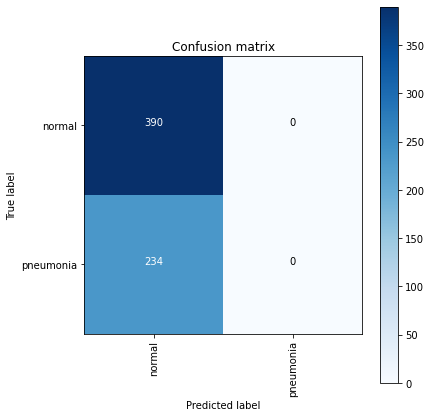

In [42]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model2, model2, test_img, test_y)
display(results_df)
plot_results(history_model2, model2, test_img, test_y)

In [43]:
# model overfit

##### 3) Baseline model with regulization and Dropout

In [44]:
model_name = "Baseline with reg, dropout"
model3 = models.Sequential()
model3.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model3.add(layers.Dense(1, activation='sigmoid'))


In [45]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model3 = model3.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model3.save(savepath)


Epoch 1/20
156/156 [==============================] - 3s 12ms/step - loss: 8.4594 - accuracy: 0.7504 - val_loss: 6.3135 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 2s 10ms/step - loss: 4.9113 - accuracy: 0.7687 - val_loss: 3.7194 - val_accuracy: 0.7691
Epoch 3/20
156/156 [==============================] - 2s 10ms/step - loss: 2.9961 - accuracy: 0.7691 - val_loss: 2.3579 - val_accuracy: 0.7691
Epoch 4/20
156/156 [==============================] - 2s 10ms/step - loss: 1.9830 - accuracy: 0.7689 - val_loss: 1.7261 - val_accuracy: 0.7691
Epoch 5/20
156/156 [==============================] - 1s 10ms/step - loss: 1.4232 - accuracy: 0.7689 - val_loss: 1.1798 - val_accuracy: 0.7691
Epoch 6/20
156/156 [==============================] - 2s 10ms/step - loss: 1.1280 - accuracy: 0.7689 - val_loss: 0.9916 - val_accuracy: 0.7691
Epoch 7/20
156/156 [==============================] - 2s 10ms/step - loss: 0.9855 - accuracy: 0.7689 - val_loss: 0.9208 - val_accuracy: 0.7691

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0


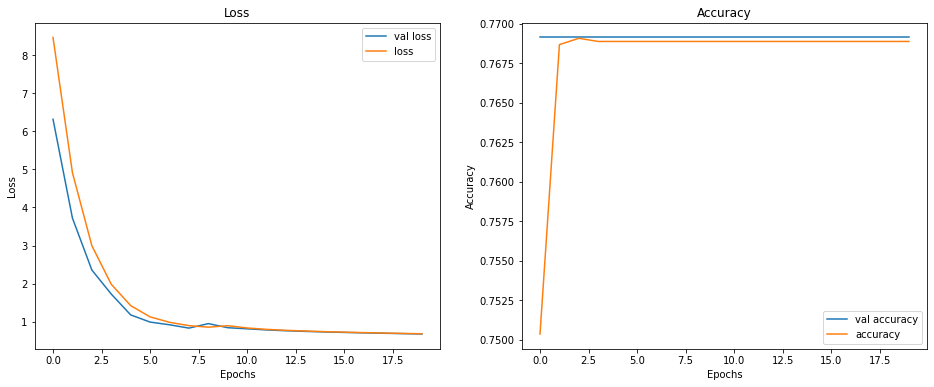

Test Accuracy = 0.62
Recall = 0.00


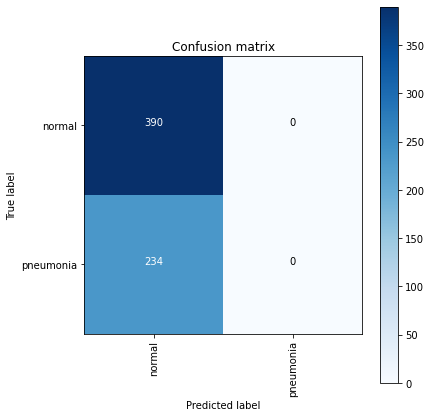

In [46]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model3, model3, test_img, test_y)
display(results_df)
plot_results(history_model3, model3, test_img, test_y)

In [47]:
# model overfit

##### 4) Baseline model with regulization and Dropout. Changed  optimizer to Adam

In [48]:
model_name = "Baseline with reg, dropout, optimizer"

model4 = models.Sequential()
model4.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dense(1, activation='sigmoid'))

In [49]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model4 = model4.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model4.save(savepath)

Epoch 1/20
156/156 [==============================] - 5s 14ms/step - loss: 2.9745 - accuracy: 0.6935 - val_loss: 1.4914 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 2s 12ms/step - loss: 1.2326 - accuracy: 0.7512 - val_loss: 0.9703 - val_accuracy: 0.7691
Epoch 3/20
156/156 [==============================] - 2s 13ms/step - loss: 0.8973 - accuracy: 0.7645 - val_loss: 0.7719 - val_accuracy: 0.7691
Epoch 4/20
156/156 [==============================] - 2s 12ms/step - loss: 0.7255 - accuracy: 0.7683 - val_loss: 0.6703 - val_accuracy: 0.7691
Epoch 5/20
156/156 [==============================] - 2s 14ms/step - loss: 0.6555 - accuracy: 0.7689 - val_loss: 0.6310 - val_accuracy: 0.7691
Epoch 6/20
156/156 [==============================] - 2s 15ms/step - loss: 0.6138 - accuracy: 0.7689 - val_loss: 0.5978 - val_accuracy: 0.7691
Epoch 7/20
156/156 [==============================] - 2s 13ms/step - loss: 0.5919 - accuracy: 0.7689 - val_loss: 0.5858 - val_accuracy: 0.7691

In [50]:
results_train4 = model4.evaluate(train_img, train_y)

156/156 [==============================] - 1s 5ms/step - loss: 0.5412 - accuracy: 0.7689


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0


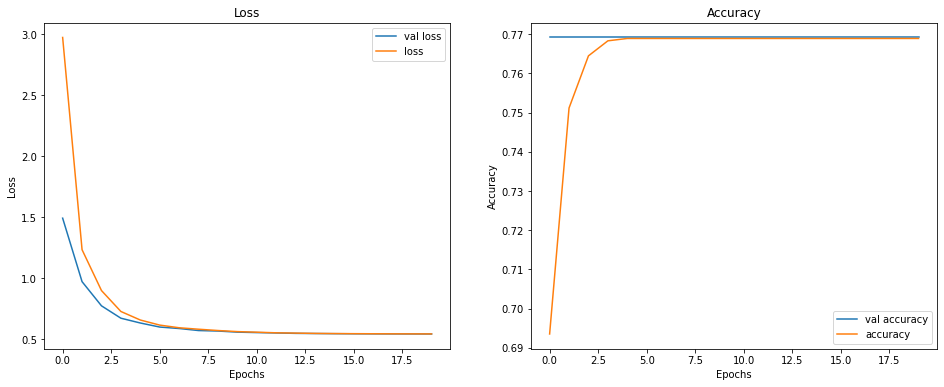

Test Accuracy = 0.62
Recall = 0.00


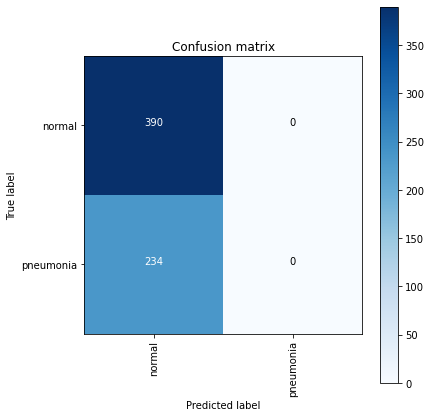

In [51]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model4, model4, test_img, test_y)
display(results_df)
plot_results(history_model4, model4, test_img, test_y)

In [52]:
results_test4 = model4.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test4[1]}")

20/20 [==============================] - 0s 4ms/step - loss: 0.7132 - accuracy: 0.6250
Test set results accuracy 0.625


In [53]:
# Model has serious overfitting issues. 

##### 5) Baseline + regulization + Dropout + Adam optimizer + increased train time

In [54]:
model_name = "Baseline with reg, dropout, optimizer + extra train time"

model5 = models.Sequential()
model5.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dense(1, activation='sigmoid'))

In [55]:
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model5 = model5.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=50,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model5.save(savepath)

Epoch 1/50
100/100 [==============================] - 2s 14ms/step - loss: 1.2671 - accuracy: 0.7467 - val_loss: 0.8628 - val_accuracy: 0.7691
Epoch 2/50
100/100 [==============================] - 1s 14ms/step - loss: 0.7435 - accuracy: 0.7679 - val_loss: 0.6239 - val_accuracy: 0.7691
Epoch 3/50
100/100 [==============================] - 1s 14ms/step - loss: 0.6125 - accuracy: 0.7689 - val_loss: 0.4924 - val_accuracy: 0.7691
Epoch 4/50
100/100 [==============================] - 1s 14ms/step - loss: 0.5548 - accuracy: 0.7695 - val_loss: 0.5421 - val_accuracy: 0.7691
Epoch 5/50
100/100 [==============================] - 1s 15ms/step - loss: 0.5765 - accuracy: 0.7681 - val_loss: 0.6541 - val_accuracy: 0.7691
Epoch 6/50
100/100 [==============================] - 1s 14ms/step - loss: 0.5657 - accuracy: 0.7689 - val_loss: 0.4437 - val_accuracy: 0.7691
Epoch 7/50
100/100 [==============================] - 1s 13ms/step - loss: 0.5213 - accuracy: 0.7689 - val_loss: 0.5261 - val_accuracy: 0.7691

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0


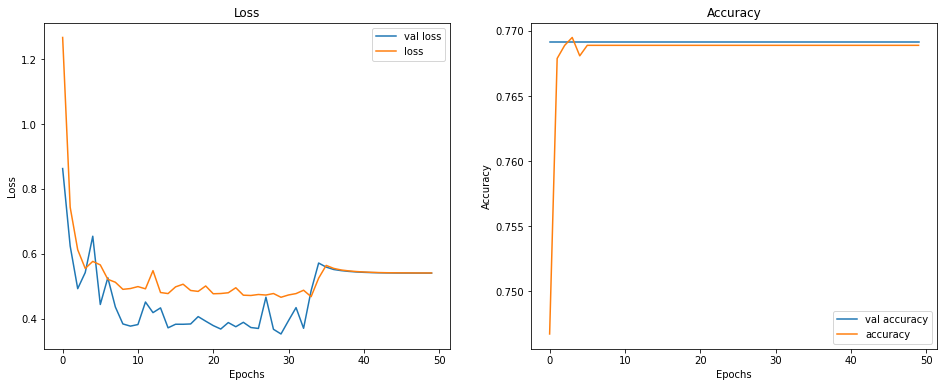

Test Accuracy = 0.62
Recall = 0.00


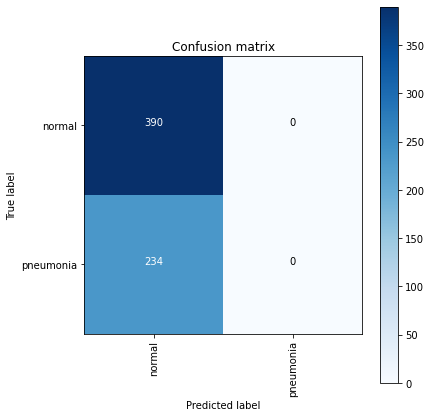

In [56]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model5, model5, test_img, test_y)
display(results_df)
plot_results(history_model5, model5, test_img, test_y)

In [57]:
results_test5 = model5.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test5[1]}")

20/20 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.6250
Test set results accuracy 0.625


In [58]:
# Model has serious overfitting issues. 

##### 6) Basic CNN model, image shape 64x64

In [59]:
model_name = "Basic CNN"

model_CNN = models.Sequential()
model_CNN.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Flatten())
model_CNN.add(layers.Dense(16, activation='relu'))
model_CNN.add(layers.Dense(1, activation='sigmoid'))

model_CNN.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [60]:
start = time.time()
history_CNN1 = model_CNN.fit(train_images,
                    train_y,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_images, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN.save(savepath)

Epoch 1/15
156/156 [==============================] - 32s 198ms/step - loss: 0.5510 - accuracy: 0.7606 - val_loss: 0.5311 - val_accuracy: 0.7691
Epoch 2/15
156/156 [==============================] - 31s 201ms/step - loss: 0.4984 - accuracy: 0.7691 - val_loss: 0.5225 - val_accuracy: 0.7691
Epoch 3/15
156/156 [==============================] - 32s 206ms/step - loss: 0.4034 - accuracy: 0.8128 - val_loss: 0.5286 - val_accuracy: 0.7691
Epoch 4/15
156/156 [==============================] - 32s 205ms/step - loss: 0.2887 - accuracy: 0.8789 - val_loss: 0.5087 - val_accuracy: 0.7749
Epoch 5/15
156/156 [==============================] - 31s 199ms/step - loss: 0.2255 - accuracy: 0.9101 - val_loss: 0.2495 - val_accuracy: 0.8846
Epoch 6/15
156/156 [==============================] - 29s 185ms/step - loss: 0.1824 - accuracy: 0.9291 - val_loss: 0.1662 - val_accuracy: 0.9234
Epoch 7/15
156/156 [==============================] - 30s 192ms/step - loss: 0.1593 - accuracy: 0.9359 - val_loss: 0.6165 - val_ac

In [61]:
results_test = model_CNN.evaluate(test_images, test_y)

20/20 [==============================] - 1s 40ms/step - loss: 0.6950 - accuracy: 0.7837


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444


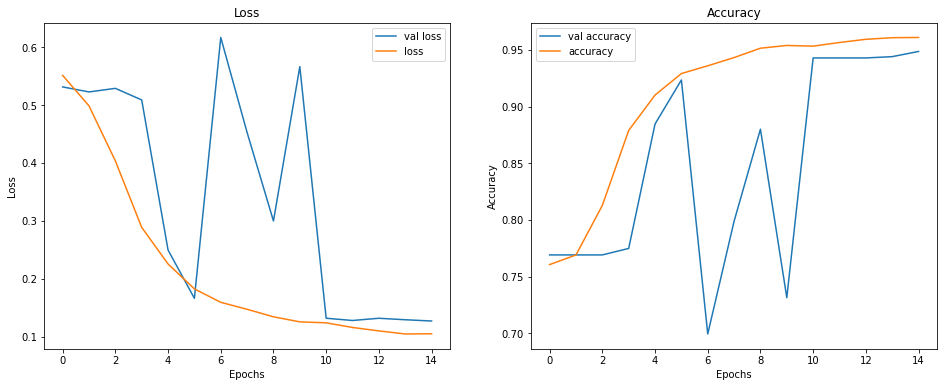

Test Accuracy = 0.78
Recall = 0.44


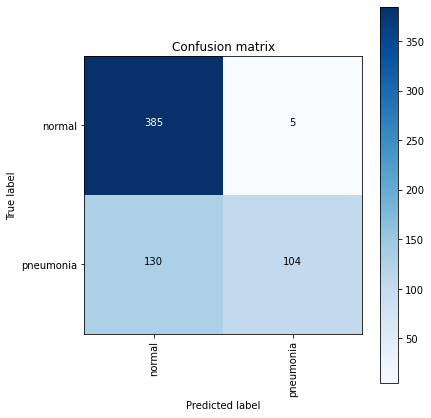

In [62]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN1, model_CNN, test_images, test_y)
display(results_df)
plot_results(history_CNN1, model_CNN, test_images, test_y)

##### 7) Basic CNN, shape 64 x 64 with regulization

In [63]:
model_name = "Basic CNN with reg, dropout"

model_CNN2 = models.Sequential()
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Flatten())
model_CNN2.add(layers.Dense(16, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [64]:
start = time.time()
history_CNN2 = model_CNN2.fit(train_images,
                    train_y,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_images, val_y))
end = time.time()
train_time = round(end-start, 0)

Epoch 1/15
156/156 [==============================] - 27s 165ms/step - loss: 0.7068 - accuracy: 0.8489 - val_loss: 0.5429 - val_accuracy: 0.8114
Epoch 2/15
156/156 [==============================] - 22s 139ms/step - loss: 0.2467 - accuracy: 0.9246 - val_loss: 0.2117 - val_accuracy: 0.9349
Epoch 3/15
156/156 [==============================] - 20s 126ms/step - loss: 0.2042 - accuracy: 0.9375 - val_loss: 0.2247 - val_accuracy: 0.9417
Epoch 4/15
156/156 [==============================] - 19s 124ms/step - loss: 0.1898 - accuracy: 0.9456 - val_loss: 0.1677 - val_accuracy: 0.9486
Epoch 5/15
156/156 [==============================] - 19s 123ms/step - loss: 0.1716 - accuracy: 0.9484 - val_loss: 0.1914 - val_accuracy: 0.9394
Epoch 6/15
156/156 [==============================] - 19s 122ms/step - loss: 0.1713 - accuracy: 0.9510 - val_loss: 0.1583 - val_accuracy: 0.9486
Epoch 7/15
156/156 [==============================] - 19s 123ms/step - loss: 0.1470 - accuracy: 0.9595 - val_loss: 0.1704 - val_ac

In [65]:
results_test = model_CNN2.evaluate(test_images, test_y)

20/20 [==============================] - 0s 21ms/step - loss: 1.5863 - accuracy: 0.6763


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368


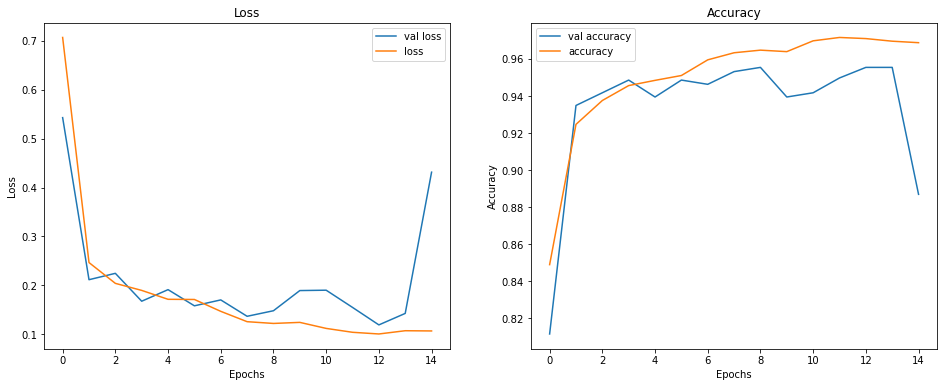

Test Accuracy = 0.68
Recall = 0.14


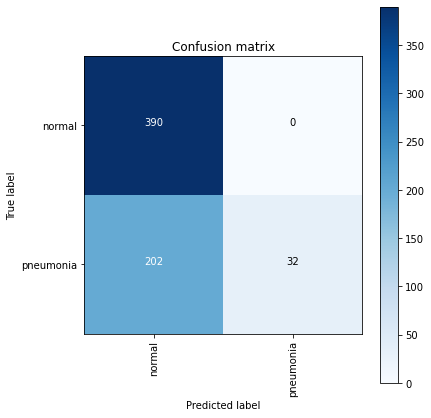

In [66]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN2, model_CNN2, test_images, test_y)
display(results_df)
plot_results(history_CNN2, model_CNN2, test_images, test_y)

##### 7) Basic CNN, shape 100 x 100

In [67]:

# Reshape images to 100x100

image_size = (100,100)
train_generator_100, val_generator_100, test_generator_100 = process_data_no_aug(image_size)

train_images2, train_labels2 = next(train_generator_100)
test_images2, test_labels2 = next(test_generator_100)
val_images2, val_labels2 = next(val_generator_100)




Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [68]:
# Reshape images
train_img2 = train_images2.reshape(train_images2.shape[0], -1)
test_img2 = test_images2.reshape(test_images2.shape[0], -1)
val_img2 = val_images2.reshape(val_images2.shape[0], -1)

# Check the shape after. 
print(train_img2.shape)
print(test_img2.shape)
print(val_img2.shape)

(4963, 30000)
(624, 30000)
(875, 30000)


In [69]:
# Labels
train_y2 = np.reshape(train_labels[:,0], (train_img_number,1))
test_y2 = np.reshape(test_labels[:,0], (test_img_number,1))
val_y2 = np.reshape(val_labels[:,0], (val_img_number,1))

In [70]:
# Create model.
model_name = "Basic CNN 100x100"

model_CNN3 = models.Sequential()
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Flatten())
model_CNN3.add(layers.Dense(16, activation='relu'))
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [71]:
start = time.time()

history_CNN3 = model_CNN3.fit(train_images2,
                    train_y2,
                    epochs=10,
                    batch_size=50,
                    validation_data=(val_images2, val_y2))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN3.save(savepath)


Epoch 1/15
100/100 [==============================] - 34s 329ms/step - loss: 0.5470 - accuracy: 0.7689 - val_loss: 0.5472 - val_accuracy: 0.7691
Epoch 2/15
100/100 [==============================] - 39s 391ms/step - loss: 0.5425 - accuracy: 0.7689 - val_loss: 0.5433 - val_accuracy: 0.7691
Epoch 3/15
100/100 [==============================] - 41s 411ms/step - loss: 0.5425 - accuracy: 0.7689 - val_loss: 0.5496 - val_accuracy: 0.7691
Epoch 4/15
100/100 [==============================] - 44s 439ms/step - loss: 0.5424 - accuracy: 0.7689 - val_loss: 0.5424 - val_accuracy: 0.7691
Epoch 5/15
100/100 [==============================] - 44s 437ms/step - loss: 0.5420 - accuracy: 0.7689 - val_loss: 0.5425 - val_accuracy: 0.7691
Epoch 6/15
100/100 [==============================] - 45s 452ms/step - loss: 0.5410 - accuracy: 0.7689 - val_loss: 0.5454 - val_accuracy: 0.7691
Epoch 7/15
100/100 [==============================] - 42s 424ms/step - loss: 0.5421 - accuracy: 0.7689 - val_loss: 0.5476 - val_ac

In [72]:
results_test = model_CNN3.evaluate(test_images2, test_y2)

20/20 [==============================] - 1s 54ms/step - loss: 0.7268 - accuracy: 0.6250


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0


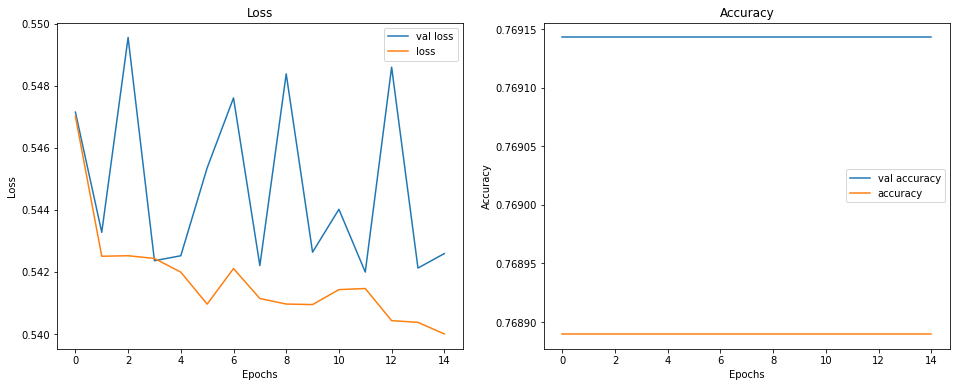

Test Accuracy = 0.62
Recall = 0.00


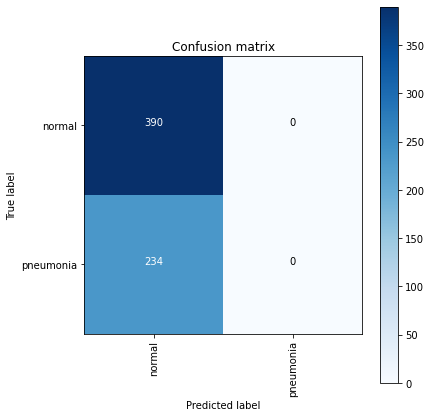

In [73]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN3, model_CNN3, test_images2, test_y2)
display(results_df)
plot_results(history_CNN3, model_CNN3, test_images2, test_y2)

##### 8) Basic CNN, shape 100 x 100 with regulization and dropout

In [74]:
model_name = "Basic CNN 100x100 with reg and dropout"

model_CNN4 = models.Sequential()
model_CNN4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Flatten())
model_CNN4.add(layers.Dense(16, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN4.add(layers.Dropout(0.3))
model_CNN4.add(layers.Dense(1, activation='sigmoid'))

model_CNN4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [75]:
start = time.time()

history_CNN4 = model_CNN4.fit(train_images2,
                    train_y2,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_images2, val_y2))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN4.save(savepath)

Epoch 1/15
156/156 [==============================] - 50s 318ms/step - loss: 0.8767 - accuracy: 0.7653 - val_loss: 0.8446 - val_accuracy: 0.7691
Epoch 2/15
156/156 [==============================] - 50s 323ms/step - loss: 0.8481 - accuracy: 0.7689 - val_loss: 0.8238 - val_accuracy: 0.7691
Epoch 3/15
156/156 [==============================] - 49s 317ms/step - loss: 0.8238 - accuracy: 0.7689 - val_loss: 0.8085 - val_accuracy: 0.7691
Epoch 4/15
156/156 [==============================] - 49s 317ms/step - loss: 0.8135 - accuracy: 0.7689 - val_loss: 0.7987 - val_accuracy: 0.7691
Epoch 5/15
156/156 [==============================] - 50s 320ms/step - loss: 0.7915 - accuracy: 0.7689 - val_loss: 0.7755 - val_accuracy: 0.7691
Epoch 6/15
156/156 [==============================] - 51s 325ms/step - loss: 0.7767 - accuracy: 0.7689 - val_loss: 0.7615 - val_accuracy: 0.7691
Epoch 7/15
156/156 [==============================] - 50s 323ms/step - loss: 0.7601 - accuracy: 0.7689 - val_loss: 0.7683 - val_ac

In [76]:
results_test = model_CNN4.evaluate(test_images2, test_y2)

20/20 [==============================] - 2s 80ms/step - loss: 0.8134 - accuracy: 0.6250


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0


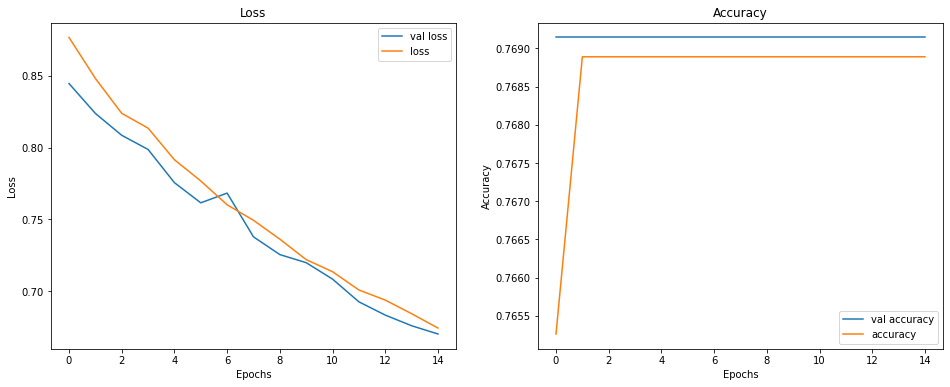

Test Accuracy = 0.62
Recall = 0.00


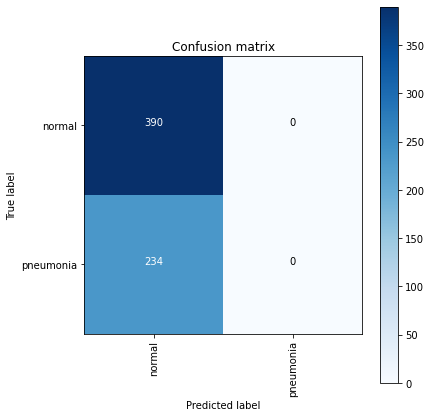

In [77]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN4, model_CNN4, test_images2, test_y2)
display(results_df)
plot_results(history_CNN4, model_CNN4, test_images2, test_y2)

##### Change data

In [78]:
image_size = (100,100)
batch_size = 120
train_generator_arg_100, val_generator_arg_100, test_generator_arg_100 = process_data_aug(image_size, batch_size)


Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [80]:
train_images_100_arg, train_labels_100_arg = next(train_generator_arg_100)
test_images_100_arg, test_labels_100_arg = next(test_generator_arg_100)
val_images_100_arg, val_labels_100_arg = next(val_generator_arg_100)

#test_y = np.reshape(test_labels_100_arg[:,], (test_img_number,1))

##### 9) Augment CNN, shape 100 x 100 with regularization

In [81]:
model_name = "Augmented CNN 100x100 with reg"

model_CNN6 = models.Sequential()
model_CNN6.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN6.add(layers.MaxPooling2D((2, 2)))
model_CNN6.add(layers.Dropout(0.2))

model_CNN6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Flatten())
model_CNN6.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN6.add(layers.Dropout(0.3))
model_CNN6.add(layers.Dense(1, activation='sigmoid'))



model_CNN6.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [82]:
start = time.time()
history_CNN6 = model_CNN6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=15, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN6.save(savepath)

Epoch 1/15
25/25 [==============================] - 95s 4s/step - loss: 1.0702 - accuracy: 0.7630 - val_loss: 0.7612 - val_accuracy: 0.7675
Epoch 2/15
25/25 [==============================] - 93s 4s/step - loss: 0.6411 - accuracy: 0.7717 - val_loss: 0.6259 - val_accuracy: 0.7700
Epoch 3/15
25/25 [==============================] - 88s 4s/step - loss: 0.5516 - accuracy: 0.7770 - val_loss: 0.5237 - val_accuracy: 0.7650
Epoch 4/15
25/25 [==============================] - 89s 4s/step - loss: 0.4922 - accuracy: 0.7625 - val_loss: 0.5062 - val_accuracy: 0.7713
Epoch 5/15
25/25 [==============================] - 89s 4s/step - loss: 0.4634 - accuracy: 0.7678 - val_loss: 0.4232 - val_accuracy: 0.8112
Epoch 6/15
25/25 [==============================] - 87s 4s/step - loss: 0.3891 - accuracy: 0.8157 - val_loss: 0.4123 - val_accuracy: 0.8612
Epoch 7/15
25/25 [==============================] - 91s 4s/step - loss: 0.4338 - accuracy: 0.8083 - val_loss: 0.4723 - val_accuracy: 0.8575
Epoch 8/15
25/25 [==

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


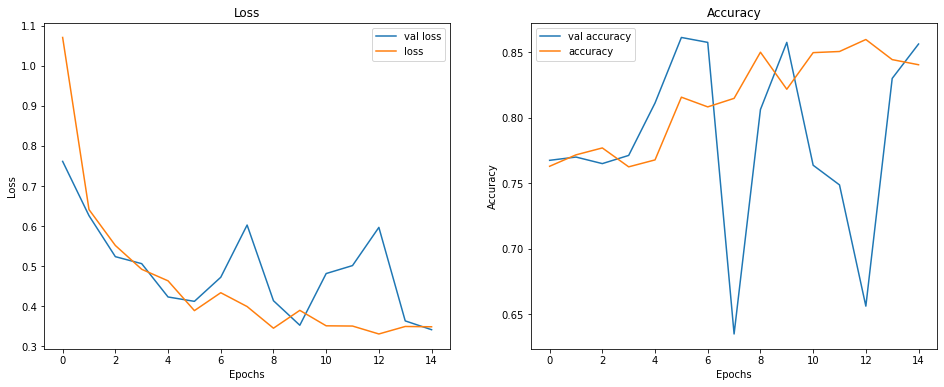

Test Accuracy = 0.50
Recall = 0.63


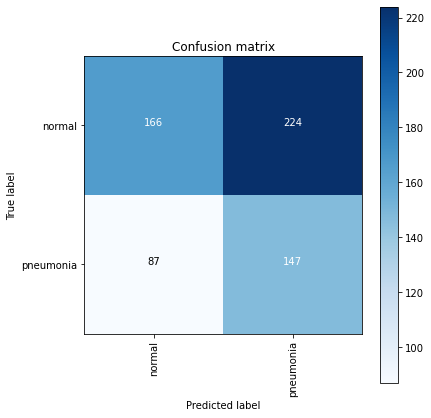

In [83]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN6, model_CNN6, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN6, model_CNN6, test_images_100_arg, test_y)

argumented CNN 100 batch 64/32 Rmsprop

##### 10) Augment CNN, shape 100 x 100 with reg and RMSprop optimizer

In [84]:
model_name = "Augmented CNN 100x100 with reg and RMSprop optimizer"

model_CNN8 = models.Sequential()
model_CNN8.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Flatten())
model_CNN8.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN8.add(layers.Dropout(0.3))
model_CNN8.add(layers.Dense(1, activation='sigmoid'))

model_CNN8.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])


In [85]:
start = time.time()

history_CNN8 = model_CNN8.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)

end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN8.save(savepath)

Epoch 1/10
25/25 [==============================] - 94s 4s/step - loss: 1.1357 - accuracy: 0.7287 - val_loss: 0.7497 - val_accuracy: 0.7725
Epoch 2/10
25/25 [==============================] - 93s 4s/step - loss: 0.6758 - accuracy: 0.7743 - val_loss: 0.6309 - val_accuracy: 0.7650
Epoch 3/10
25/25 [==============================] - 93s 4s/step - loss: 0.6017 - accuracy: 0.7726 - val_loss: 0.5723 - val_accuracy: 0.7700
Epoch 4/10
25/25 [==============================] - 93s 4s/step - loss: 0.5683 - accuracy: 0.7699 - val_loss: 0.5426 - val_accuracy: 0.7763
Epoch 5/10
25/25 [==============================] - 91s 4s/step - loss: 0.5369 - accuracy: 0.7778 - val_loss: 0.6783 - val_accuracy: 0.7688
Epoch 6/10
25/25 [==============================] - 92s 4s/step - loss: 0.5431 - accuracy: 0.7621 - val_loss: 0.5266 - val_accuracy: 0.7713
Epoch 7/10
25/25 [==============================] - 91s 4s/step - loss: 0.5211 - accuracy: 0.7686 - val_loss: 0.5393 - val_accuracy: 0.7663
Epoch 8/10
25/25 [==

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


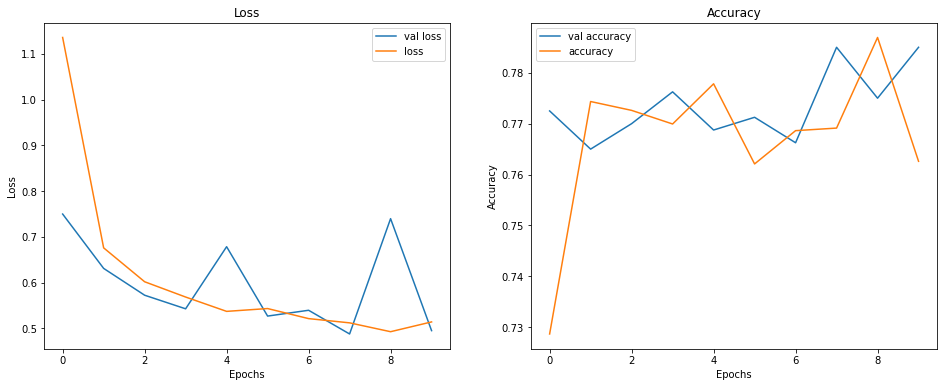

Test Accuracy = 0.38
Recall = 0.97


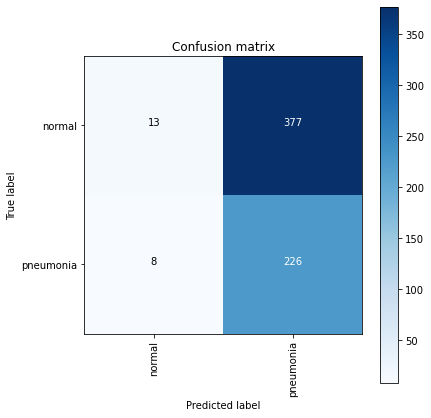

In [86]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN8, model_CNN8, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN8, model_CNN8, test_images_100_arg, test_y)

In [87]:
results_test = model_CNN8.evaluate(test_images_100_arg, test_y)

20/20 [==============================] - 1s 63ms/step - loss: 1.2332 - accuracy: 0.3830


##### 11) Augment CNN, shape 100 x 100 with reg with additional regularizer

In [88]:
model_name = "Augmented CNN 100x100 with additional reg, increased training time"
model_CNN9 = models.Sequential()
model_CNN9.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Flatten())
model_CNN9.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN9.add(layers.Dropout(0.3))
model_CNN9.add(layers.Dense(1, activation='sigmoid'))

model_CNN9.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [89]:
start = time.time()
history_CNN9 = model_CNN9.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=30, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)

end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN9.save(savepath)

Epoch 1/30
25/25 [==============================] - 94s 4s/step - loss: 1.0343 - accuracy: 0.7670 - val_loss: 0.7193 - val_accuracy: 0.7713
Epoch 2/30
25/25 [==============================] - 94s 4s/step - loss: 0.6596 - accuracy: 0.7661 - val_loss: 0.6089 - val_accuracy: 0.7725
Epoch 3/30
25/25 [==============================] - 92s 4s/step - loss: 0.5554 - accuracy: 0.7635 - val_loss: 0.5627 - val_accuracy: 0.7663
Epoch 4/30
25/25 [==============================] - 89s 4s/step - loss: 0.5153 - accuracy: 0.7661 - val_loss: 0.6335 - val_accuracy: 0.7675
Epoch 5/30
25/25 [==============================] - 92s 4s/step - loss: 0.5155 - accuracy: 0.7635 - val_loss: 0.4933 - val_accuracy: 0.7887
Epoch 6/30
25/25 [==============================] - 91s 4s/step - loss: 0.4731 - accuracy: 0.7852 - val_loss: 0.5082 - val_accuracy: 0.7713
Epoch 7/30
25/25 [==============================] - 91s 4s/step - loss: 0.4551 - accuracy: 0.7857 - val_loss: 0.4719 - val_accuracy: 0.8163
Epoch 8/30
25/25 [==

In [90]:
results_test = model_CNN9.evaluate(test_images_100_arg, test_y)

20/20 [==============================] - 2s 80ms/step - loss: 1.6937 - accuracy: 0.4615


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


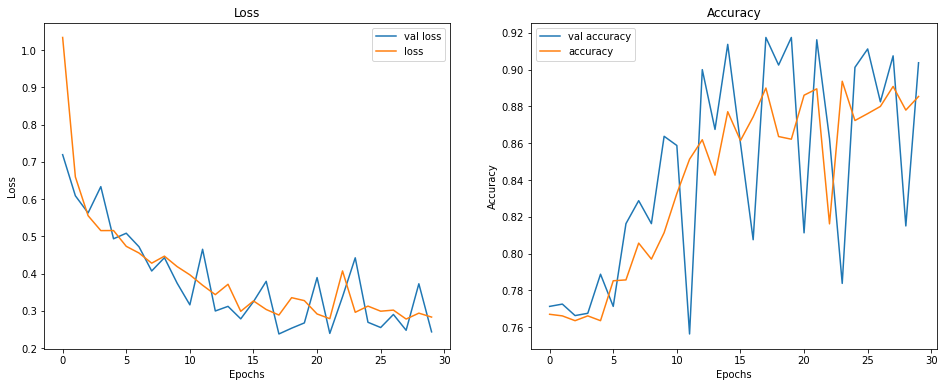

Test Accuracy = 0.46
Recall = 0.69


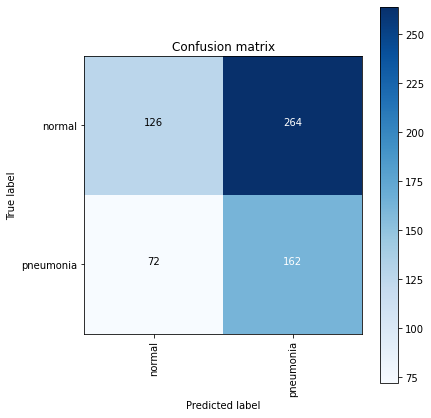

In [91]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN9, model_CNN9, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN9, model_CNN9, test_images_100_arg, test_y)

##### 12) Pre-trained Augmented CNN 100x100 frozen layer VGG16

In [92]:
model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16, batch 92"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False
model_new7 = models.Sequential()
model_new7.add(base_model_cnn)
model_new7.add(layers.Flatten())
model_new7.add(layers.Dropout(0.3))
model_new7.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new7.add(layers.Dropout(0.3))
model_new7.add(layers.Dense(1,activation="sigmoid"))
model_new7.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])
start = time.time()
history__new7 = model_new7.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_new7.save(savepath)

Epoch 1/10
25/25 [==============================] - 162s 6s/step - loss: 1.1262 - accuracy: 0.7978 - val_loss: 0.6076 - val_accuracy: 0.9112
Epoch 2/10
25/25 [==============================] - 156s 6s/step - loss: 0.5269 - accuracy: 0.8723 - val_loss: 0.4343 - val_accuracy: 0.9100
Epoch 3/10
25/25 [==============================] - 150s 6s/step - loss: 0.4368 - accuracy: 0.8763 - val_loss: 0.3507 - val_accuracy: 0.9175
Epoch 4/10
25/25 [==============================] - 144s 6s/step - loss: 0.3970 - accuracy: 0.8828 - val_loss: 0.3138 - val_accuracy: 0.9337
Epoch 5/10
25/25 [==============================] - 145s 6s/step - loss: 0.3792 - accuracy: 0.8865 - val_loss: 0.3626 - val_accuracy: 0.8925
Epoch 6/10
25/25 [==============================] - 148s 6s/step - loss: 0.3738 - accuracy: 0.8885 - val_loss: 0.2721 - val_accuracy: 0.9463
Epoch 7/10
25/25 [==============================] - 142s 6s/step - loss: 0.3641 - accuracy: 0.8749 - val_loss: 0.4174 - val_accuracy: 0.8475
Epoch 8/10
25

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


FileNotFoundError: [Errno 2] No such file or directory: './img/Loss_Pre-trained Augmented CNN 100x100 frozen layer VGG16, batch 92/32.png'

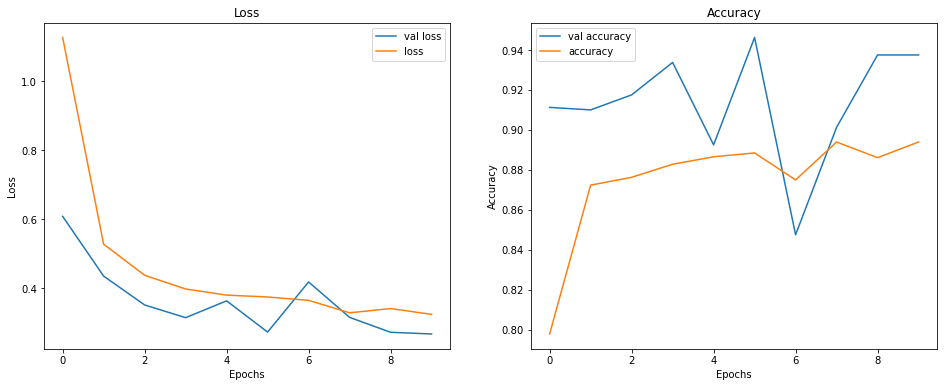

In [93]:
results_df = make_results(results_df,image_size,train_time,model_name,history__new7, model_new7, test_images_100_arg, test_y)
display(results_df)
plot_results(history__new7, model_new7, test_images_100_arg, test_y)

##### 12) Pre-trained Augmented CNN 100x100 frozen layer VGG16 batch 64/32

In [94]:
image_size = (100,100)
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=image_size, 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=image_size,
        batch_size = 24,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=image_size,
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.


##### 13) Pre-trained Augmented CNN 100x100 frozen layer VGG16 with class weights

In [95]:
model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16 with weights"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False
model_new4 = models.Sequential()
model_new4.add(base_model_cnn)
model_new4.add(layers.Flatten())
model_new4.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new4.add(layers.Dropout(0.3))
model_new4.add(layers.Dense(1,activation="sigmoid"))
model_new4.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])
start = time.time()
history__new4 = model_new4.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25, class_weight = {0: 2, 1: 1})
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_new4.save(savepath)

Epoch 1/10
25/25 [==============================] - 107s 4s/step - loss: 1.2813 - accuracy: 0.8160 - val_loss: 0.8310 - val_accuracy: 0.7833
Epoch 2/10
25/25 [==============================] - 106s 4s/step - loss: 0.6467 - accuracy: 0.8869 - val_loss: 0.5228 - val_accuracy: 0.8783
Epoch 3/10
25/25 [==============================] - 113s 5s/step - loss: 0.5137 - accuracy: 0.9083 - val_loss: 0.5510 - val_accuracy: 0.8400
Epoch 4/10
25/25 [==============================] - 112s 4s/step - loss: 0.4595 - accuracy: 0.9119 - val_loss: 0.3783 - val_accuracy: 0.9033
Epoch 5/10
25/25 [==============================] - 111s 4s/step - loss: 0.4776 - accuracy: 0.8988 - val_loss: 0.3544 - val_accuracy: 0.9183
Epoch 6/10
25/25 [==============================] - 109s 4s/step - loss: 0.4497 - accuracy: 0.9038 - val_loss: 0.3714 - val_accuracy: 0.8950
Epoch 7/10
25/25 [==============================] - 107s 4s/step - loss: 0.3767 - accuracy: 0.9262 - val_loss: 0.3052 - val_accuracy: 0.9300
Epoch 8/10
25

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


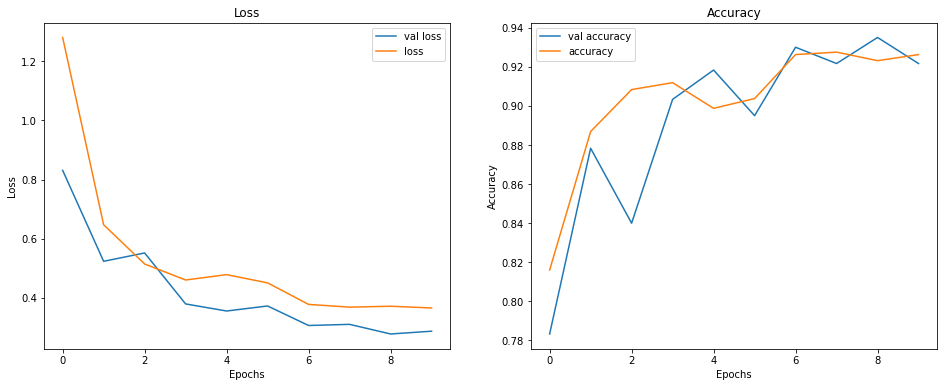

Test Accuracy = 0.54
Recall = 0.67


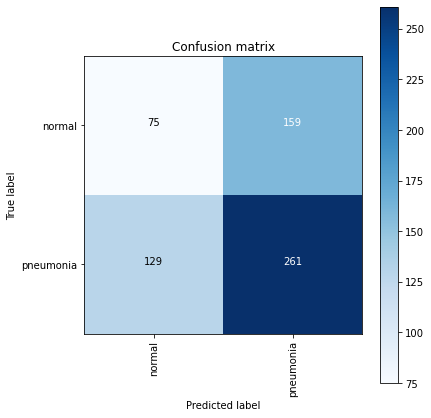

In [96]:
results_df = make_results(results_df,image_size,train_time,model_name,history__new4, model_new4, test_images_100_arg, test_y)
display(results_df)
plot_results(history__new4, model_new4, test_images_100_arg, test_y)

##### 14) Pre-trained Augmented CNN 100x100 frozen layer VGG16 with class weights

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 89s 3s/step - loss: 1.1323 - accuracy: 0.7781 - val_loss: 0.5896 - val_accuracy: 0.9000
Epoch 2/10
25/25 [==============================] - 101s 4s/step - loss: 0.5210 - accuracy: 0.8656 - val_loss: 0.3643 - val_accuracy: 0.9560
Epoch 3/10
25/25 [==============================] - 103s 4s/step - loss: 0.4010 - accuracy: 0.8869 - val_loss: 0.3258 - val_accuracy: 0.9320
Epoch 4/10
25/25 [==============================] - 94s 4s/step - loss: 0.3407 - accuracy: 0.9069 - val_loss: 0.3089 - val_accuracy: 0.9320
Epoch 5/10
25/25 [==============================] - 95s 4s/step - loss: 0.3379 - accuracy: 0.9050 - val_loss: 0.2526 - val_accuracy: 0.9440
Epoch 6/10
25/25 [==============================] - 100s 4s/step - loss: 0.3067 - accuracy: 0.9100 - val_loss: 0.2526 - val_accuracy: 0.9400
Epoch 7/10
25/25 [===============

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


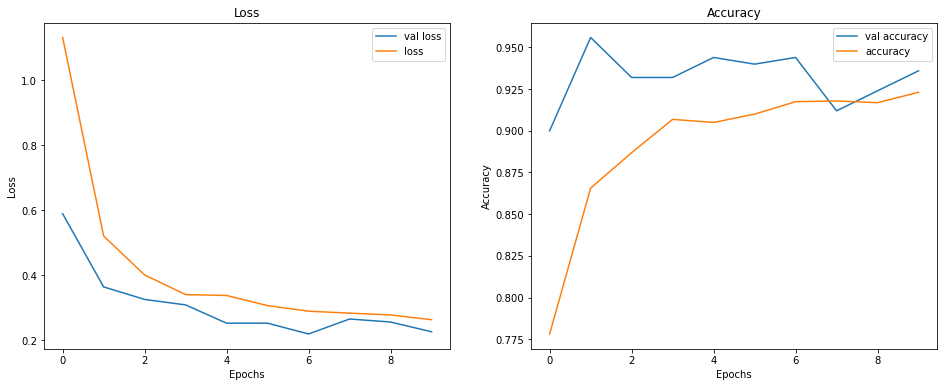

Test Accuracy = 0.83
Recall = 0.98


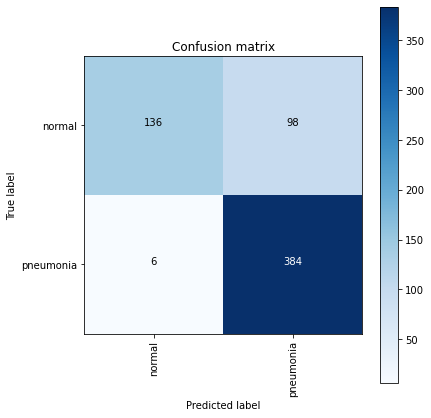

In [97]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(100, 100), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(100, 100),
        batch_size = 10,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=(100, 100),
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new6 = models.Sequential()
model_new6.add(base_model_cnn)
model_new6.add(layers.Flatten())
model_new6.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.2))
model_new6.add(layers.Dense(1,activation="sigmoid"))
model_new6.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new6 = model_new6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new6, model_new6, test_images, test_y)
display(results_df)
plot_results(history__new6, model_new6, test_images, test_y)
savepath = "./data/models/"+model_name+".h5"
model_new6.save(savepath)

##### 15) Pre-trained Augmented CNN 224x224 with MobileNetV2. 

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.
Epoch 1/14
25/25 [==============================] - 104s 4s/step - loss: 1.8020 - accuracy: 0.8625 - val_loss: 1.1861 - val_accuracy: 0.9000
Epoch 2/14
25/25 [==============================] - 94s 4s/step - loss: 0.9888 - accuracy: 0.9237 - val_loss: 0.8618 - val_accuracy: 0.9080
Epoch 3/14
25/25 [==============================] - 106s 4s/step - loss: 0.7258 - accuracy: 0.9388 - val_loss: 0.6572 - val_accuracy: 0.9240
Epoch 4/14
25/25 [==============================] - 97s 4s/step - loss: 0.5747 - accuracy: 0.9375 - val_loss: 0.5129 - val_accuracy: 0.9600
Epoch 5/14
25/25 [==============================] - 93s 4s/step - loss: 0.5227 - accuracy: 0.9281 - val_loss: 0.4510 - val_accuracy: 0.9560
Epoch 6/14
25/25 [==============================] - 91s 4s/step - loss: 0.4197 - accuracy: 0.9481 - val_loss: 0.4018 - val_accuracy: 0.9360
Epoch 7/14
25/25 [================

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


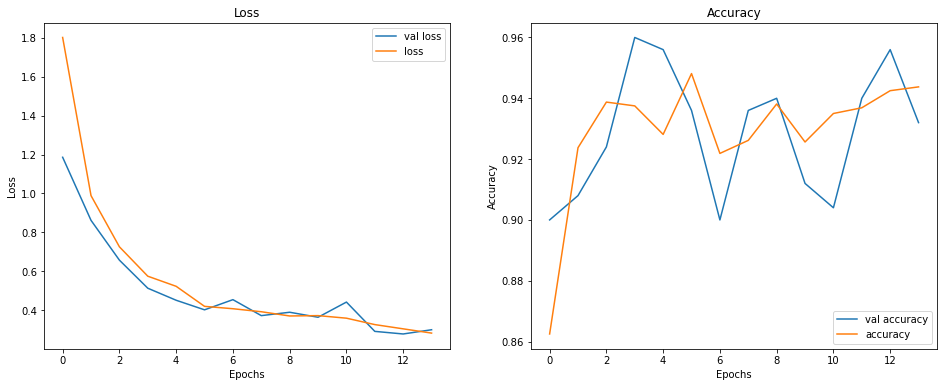

Test Accuracy = 0.95
Recall = 0.96


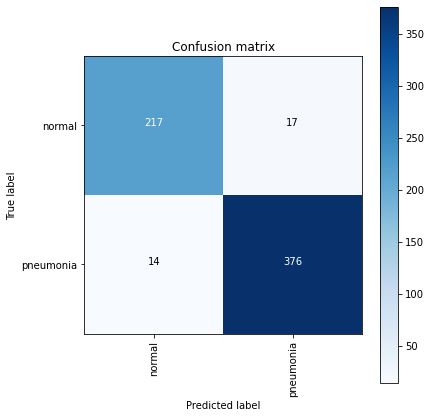

In [99]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224, 224),
        batch_size = 10,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=(224, 224),
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 224x224 frozen layer MobileNetV2"

base_model_cnn = MobileNetV2(weights='imagenet',
        include_top=False, 
        input_shape=(224,224,3))
        
# Freeze VGG layer
base_model_cnn.trainable = False

model_new10 = models.Sequential()
model_new10.add(base_model_cnn)
model_new10.add(layers.Flatten())
model_new10.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new10.add(layers.Dropout(0.2))
model_new10.add(layers.Dense(1,activation="sigmoid"))
model_new10.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new10 = model_new10.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=14, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new10, model_new10, test_images, test_y)
display(results_df)
plot_results(history__new10, model_new10, test_images, test_y)
savepath = "./data/models/"+model_name+".h5"
model_new10.save(savepath)

##### 16) Pre-trained Augmented CNN 224x224 with VGG16

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 410s 16s/step - loss: 1.0576 - accuracy: 0.7706 - val_loss: 0.5006 - val_accuracy: 0.9050
Epoch 2/10
25/25 [==============================] - 413s 17s/step - loss: 0.4630 - accuracy: 0.8981 - val_loss: 0.4023 - val_accuracy: 0.9050
Epoch 3/10
25/25 [==============================] - 409s 16s/step - loss: 0.3682 - accuracy: 0.9044 - val_loss: 0.3406 - val_accuracy: 0.9150
Epoch 4/10
25/25 [==============================] - 408s 16s/step - loss: 0.3019 - accuracy: 0.9256 - val_loss: 0.2753 - val_accuracy: 0.9325
Epoch 5/10
25/25 [==============================] - 411s 16s/step - loss: 0.2832 - accuracy: 0.9312 - val_loss: 0.2320 - val_accuracy: 0.9500
Epoch 6/10
25/25 [==============================] - 408s 16s/step - loss: 0.3087 - accuracy: 0.9056 - val_loss: 0.3869 - val_accuracy: 0.8650
Epoch 7/10
25/25 [======

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


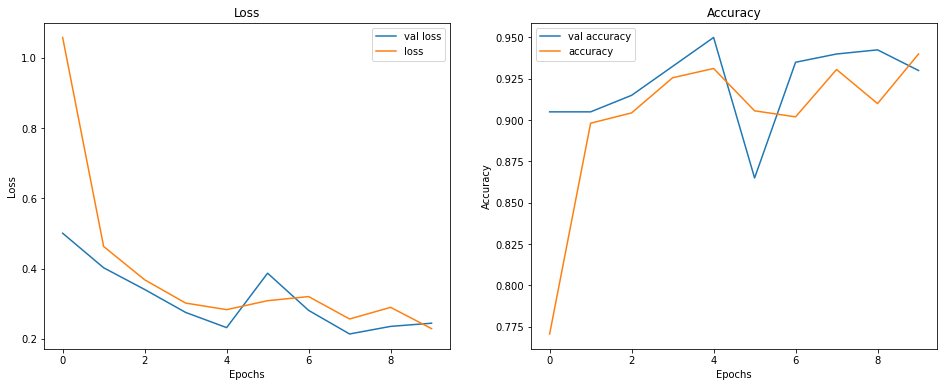

Test Accuracy = 0.93
Recall = 0.98


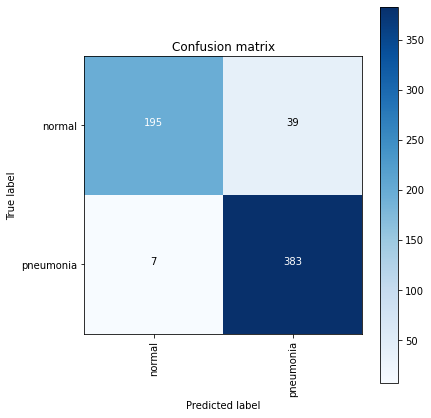

In [100]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224, 224),
        batch_size = 16,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=(224, 224),
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 224x224 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(224,224,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new6 = models.Sequential()
model_new6.add(base_model_cnn)
model_new6.add(layers.Flatten())
model_new6.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.2))
model_new6.add(layers.Dense(1,activation="sigmoid"))
model_new6.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new6 = model_new6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new6, model_new6, test_images, test_y)
display(results_df)
plot_results(history__new6, model_new6, test_images, test_y)
savepath = "./data/models/"+model_name+".h5"
model_new6.save(savepath)

##### 17) Pre-trained Augmented CNN 200x200 frozen layer VGG16

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 323s 13s/step - loss: 1.2146 - accuracy: 0.7925 - val_loss: 0.5586 - val_accuracy: 0.9350
Epoch 2/10
25/25 [==============================] - 353s 14s/step - loss: 0.5242 - accuracy: 0.8956 - val_loss: 0.4304 - val_accuracy: 0.9225
Epoch 3/10
25/25 [==============================] - 383s 15s/step - loss: 0.3729 - accuracy: 0.9255 - val_loss: 0.3234 - val_accuracy: 0.9400
Epoch 4/10
25/25 [==============================] - 335s 13s/step - loss: 0.3430 - accuracy: 0.9156 - val_loss: 0.3140 - val_accuracy: 0.9150
Epoch 5/10
25/25 [==============================] - 330s 13s/step - loss: 0.3053 - accuracy: 0.9187 - val_loss: 0.2680 - val_accuracy: 0.9450
Epoch 6/10
25/25 [==============================] - 391s 16s/step - loss: 0.2668 - accuracy: 0.9306 - val_loss: 0.2359 - val_accuracy: 0.9550
Epoch 7/10
25/25 [======

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


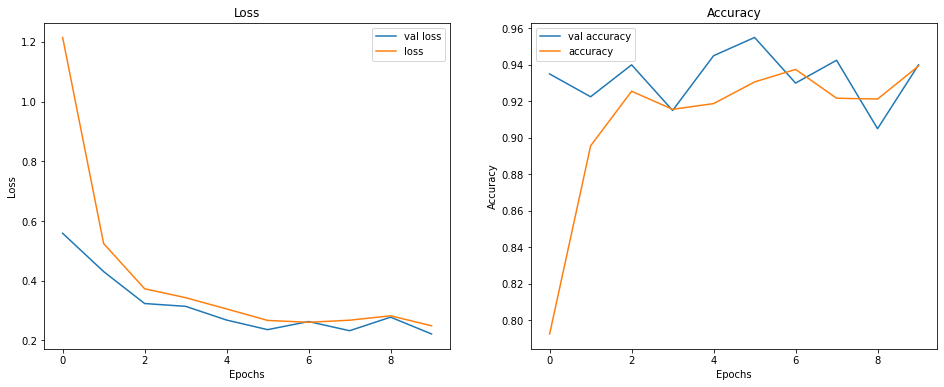

Test Accuracy = 0.93
Recall = 0.97


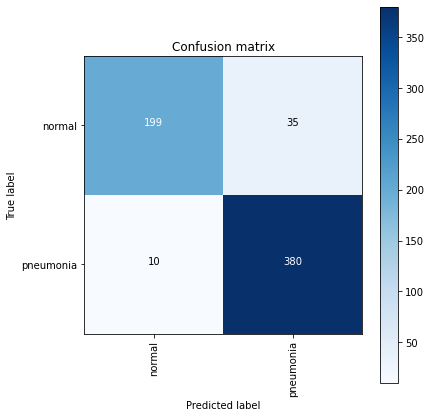

In [101]:
image_size = (200,200)
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=image_size, 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=image_size,
        batch_size = 16,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=image_size,
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 200x200 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(200,200,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new3 = models.Sequential()
model_new3.add(base_model_cnn)
model_new3.add(layers.Flatten())
model_new3.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new3.add(layers.Dropout(0.2))
model_new3.add(layers.Dense(1,activation="sigmoid"))
model_new3.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])


start = time.time()
history__new3 = model_new3.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new3, model_new3, test_images, test_y)
display(results_df)
plot_results(history__new3, model_new3, test_images, test_y)
model_new3.save('data/models/model_new6.h5')
savepath = "./data/models/"+model_name+".h5"
model_new3.save(savepath)



In [163]:
results_df

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",614971,12.0,0.9514,0.4834,0.6266,0.9915
0,Baseline with reg,"(64, 64)",615996,31.0,0.9061,0.7749,0.625,0.0
0,"Baseline with reg, dropout","(64, 64)",615996,31.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,40.0,0.7689,0.7691,0.625,0.0
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,83.0,0.7689,0.7691,0.625,0.0
0,Basic CNN,"(64, 64)",107553,456.0,0.9609,0.9486,0.7837,0.4444
0,"Basic CNN with reg, dropout","(64, 64)",72705,293.0,0.9688,0.8869,0.6763,0.1368
0,Basic CNN 100x100,"(100, 100)",138241,617.0,0.7689,0.7691,0.625,0.0
0,Basic CNN 100x100 with reg and dropout,"(100, 100)",173089,756.0,0.7689,0.7691,0.625,0.0
0,Augmented CNN 100x100 with reg,"(100, 100)",376421,1359.0,0.8404,0.8562,0.5016,0.6282


##### Fine tuning
`

In [103]:
# Finall model has resolution 224x224, lets generate images in required resolution for this model:

test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = test_img_number,
        class_mode='binary') 
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))

# Define best model
best_model = model_new10
test_images_in_resolution = test_images
test_images_labels = test_y
predictions = best_model.predict(test_images_in_resolution)
predictions_base = [1 if x > 0.5 else 0 for x in predictions]
test_accuracy_base = round(accuracy_score(test_images_labels, predictions_base),4)
test_recall_base = round(recall_score(test_images_labels, predictions_base),4)

Found 624 images belonging to 2 classes.


In [104]:
# Loop with changing prediction bondaries
list_of_thresholds = list(np.linspace(0.2, 0.8, 13))
list_of_options=[]
for threshold in list_of_thresholds:
    prediction_new = [1 if x > threshold else 0 for x in predictions]
    test_accuracy = round(accuracy_score(test_images_labels, prediction_new),4)
    test_recall = round(recall_score(test_images_labels, prediction_new),4)
    list_of_options.append((threshold, test_accuracy, test_recall))
    

In [105]:
# Base model predictions
print("Optimization focusen on accuracy")
print(f"Model accuracy {test_accuracy_base}. Model recall {test_recall_base}")


# Best prediction threshold for accuracy
threshold_acc = sorted(list_of_options, key = lambda x: x[1], reverse = True)[0]
print("Optimization focusen on accuracy")
print(f"Model accuracy {threshold_acc[1]}. Model recall {threshold_acc[2]}")


# Best prediction threshold for recall
threshold_recall = sorted(list_of_options, key = lambda x: x[2], reverse = True)[0]
print("Optimization focusen on recall")
print(f"Model accuracy {threshold_recall[1]}. Model recall {threshold_recall[2]}")



Optimization focusen on accuracy
Model accuracy 0.9503. Model recall 0.9641
Optimization focusen on accuracy
Model accuracy 0.9519. Model recall 0.9769
Optimization focusen on recall
Model accuracy 0.9135. Model recall 0.9949


Doubious cases investigation:
Doubious cases that were removed: 6.41%
Model accuracy after removal 0.9726. Model recall after removal 0.992


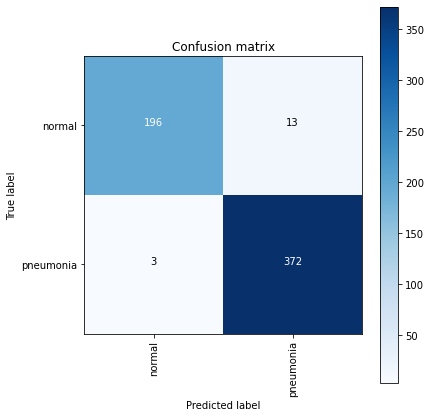

In [162]:
# Dubious cases removal
lower_border = 0.25
upper_border = 0.55
new_list = zip (test_images_labels, predictions)
new_predictions = [item for item in new_list if ((item[1] > upper_border) or (item[1] < lower_border))]
new_test_set = [new_prediction[0] for new_prediction in new_predictions]
new_predictions_after = [1 if x[1] > 0.5 else 0 for x in new_predictions]
new_accuracy = round(accuracy_score(new_test_set, new_predictions_after),4)
new_recall = round(recall_score(new_test_set, new_predictions_after),4)
print(f"Doubious cases investigation:")
print(f"Doubious cases that were removed: {round((1-len(new_predictions)/len(predictions))*100,2 )}%")
print(f"Model accuracy after removal {new_accuracy}. Model recall after removal {new_recall}")
confusion_mtx = confusion_matrix(new_test_set, new_predictions_after)
cm = plot_confusion_matrix(confusion_mtx, classes = ["normal", "pneumonia"], normalize=False)

# Conclusion
---
Based on results our finall model will be: "Pre-trained Augmented CNN 224x224 frozen layer MobileNetV2"

With the following parameters after tuning:

Accuracy - 0.9519

Recall - 0.9769

Because of the following reasons: 

1) It satisfy requirements on recall (higher 0.95).

2) It has high accuracy. 

Another solution for this problem might be identify cases that has probability between classes and send it to firther investigation by takeholder.
We are interested in maximizing racall (min FN) so we will remove prediction not equally from decision boundary, but we will drop cases with probabiblity 0.25-0.55 
This approach allows us to get accuracy 0.9726 and recall 0.992

Overall, this data tells us that current X-ray have enought information so we can be sure that each patient will be treated well. 